### Install the beacon_api package to interact with the Beacon Data Lake API

You can find the package on PyPI: https://pypi.org/project/beacon-api/

If you run into any issues, please refer to the GitHub repository: https://github.com/maris-development/beacon

Documentation for the beacon_api package can be found here: https://maris-development.github.io/beacon/docs/1.2.0/query-docs/getting-started.html#python

Documentation for the Beacon Data Lake technology can be found here: https://maris-development.github.io/beacon/

In [17]:
%pip install beacon_api --upgrade --break
from beacon_api import * # Import the Beacon API client
import os

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### In order to get access to the Beacon endpoint, you will need a token.

The notebook will fetch the Token for you when running in the D4science VRE.
If you are running the notebook outside the D4Science VRE you will need to get the token from the D4science VRE and fill it in manually.


In [ ]:
TOKEN = os.getenv('D4SCIENCE_TOKEN') # This will fetch the token from the VRE environment.
# If you want to run this notebook locally, you can set the TOKEN variable directly here:
#TOKEN = "<your_token>" # Get your token from https://blue-cloud.d4science.org/group/blue-cloudlab/authorization. Simply press "Get Token" and copy the token here.
TOKEN = "<your_token>"
BEACON_INSTANCE_URL = "https://beacon-cora-pr.maris.nl" # Can optionally be replaced with the Beacon running on D4Science: https://beacon-cora-pr.d4science.org

#### Connect to the Beacon Data Lake


In [28]:
if TOKEN is None:
    raise ValueError("TOKEN is not set. Please set the TOKEN variable with your actual token.")
client = Client(BEACON_INSTANCE_URL, jwt_token=TOKEN)

Connected to: https://beacon-cora-pr.maris.nl/ server successfully


#### List the available columns and their data types (e.g., string, integer) that can be queried.


In [31]:
available_columns = client.available_columns_with_data_type()
# Search for all available columns where the column name contains a specific keyword or part of it
search_keyword = "feature"
matching_columns = [col.name for col in available_columns if search_keyword.lower() in col.name.lower()]
matching_columns

[]

#### Build a query


In [ ]:
# Input parameters
regionname = "Med"
BDI = "CORA_PR"
bigram="PF"
mindate = "2000-01-01T00:00:00"
maxdate = "2015-12-31T23:59:59"
minlon = -8
maxlon = 36.5
minlat = 30
maxlat = 46
region = [
    (-9.50, 30.00),
    (-9.50, 39.00),
    (-0.80, 43.20),
    (16.00, 46.50),
    (36.50, 38.00),
    (36.50, 30.00),
    (-9.50, 30.00)
]
mindepth = 0
maxdepth = 150
format = "pandas" # Options are: pandas, geopandas, netcdf, zarr, parquet, geoparquet, odv, arrow, csv
output_file_name = f"{BDI}_{regionname}"
df = None
gdf = None

# Here we build the query step by step. First we select the columns we want to retrieve, then we add the filters and finally we specify the output format.
query_builder = client.query()

query_builder.add_select_column("TIME", alias="TIME")  # Select the columns you want to retrieve
query_builder.add_select_column("TIME_QC", alias="TIME_QC")
query_builder.add_select_column("LONGITUDE") 
query_builder.add_select_column("LATITUDE")
query_builder.add_select_column("POSITION_QC") 
query_builder.add_select_column("DC_REFERENCE")
query_builder.add_select_column("PLATFORM_NUMBER")
query_builder.add_select_column("INSTITUTION_EDMO_CODE", alias="EDMO_CODE") 
query_builder.add_select_column("WMO_INST_TYPE")
query_builder.add_select_column(".bigram", alias="BIGRAM")
# Add a new column "depth" which is the first non-null value from DEPH_ADJUSTED, DEPH or the calculated depth from PRES_ADJUSTED or PRES column which is converted using teos-10 formula
query_builder.add_select(
    Functions.coalesce(
        [
            Functions.coalesce(["DEPH_ADJUSTED", "DEPH"], alias="depth_merged"),
            Functions.map_pressure_to_depth(
                Functions.coalesce(["PRES_ADJUSTED", "PRES"], alias="pres_merged"),
                "LATITUDE",
                alias="depth_from_pres",
            ),
        ],
        alias="DEPTH",
    )
)
query_builder.add_select_coalesced(["DEPH_ADJUSTED_QC","DEPH_QC","PRES_ADJUSTED_QC","PRES_QC"], alias="DEPTH_QC")

query_builder.add_select_column("TEMP", "TEMPERATURE")  
query_builder.add_select_column("TEMP_QC", "TEMPERATURE_QC") 
query_builder.add_select_column("PSAL", "SALINITY")
query_builder.add_select_column("PSAL_QC", "SALINITY_QC")
query_builder.add_select_column("PROFILE_QC")

## Add the filters
query_builder.add_range_filter("TIME", mindate, maxdate)  # You can adjust the date range as needed. The format is ISO 8601.
query_builder.add_equals_filter("TIME_QC", 1)  # Only good quality time
query_builder.add_range_filter("LATITUDE", minlat, maxlat)  # Latitude range from -90 to 90 (you can adjust as needed)
query_builder.add_range_filter("LONGITUDE", minlon, maxlon)  # Longitude range
# query_builder.add_polygon_filter("LONGITUDE","LATITUDE", region)  # Define a polygon area (you can adjust the coordinates as needed)
query_builder.add_equals_filter("POSITION_QC", 1)  # Only good quality position
query_builder.add_filter(OrFilter([IsNotNullFilter("TEMPERATURE"), IsNotNullFilter("SALINITY")]))  # Ensure at least Temperature or Salinity is not null
query_builder.add_filter(
    OrFilter([EqualsFilter("TEMPERATURE_QC", 1), EqualsFilter("SALINITY_QC", 1)])
)  # Only good quality temperature or salinity
query_builder.add_equals_filter("DEPTH_QC", 1)  # Only good quality depth
query_builder.add_range_filter("DEPTH", mindepth, maxdepth)  # Depth range from 0 to 50 meters (you can adjust as needed)

# Add the output format
if format == "pandas":
    df = query_builder.to_pandas_dataframe()
elif format == "geopandas":
    gdf = query_builder.to_geo_pandas_dataframe(longitude_column="LONGITUDE", latitude_column="LATITUDE")
elif format == "netcdf":
    query_builder.to_netcdf(output_file_name + ".nc")
elif format == "zarr":
    query_builder.to_zarr(output_file_name + ".zarr")
elif format == "parquet":
    query_builder.to_parquet(output_file_name + ".parquet")
elif format == "geoparquet":
    query_builder.to_geoparquet(output_file_name + ".parquet", longitude_column="LONGITUDE", latitude_column="LATITUDE")
elif format == "odv":
    odv_output = Odv(
        longitude_column=OdvDataColumn("LONGITUDE"),
        latitude_column=OdvDataColumn("LATITUDE"),
        time_column=OdvDataColumn("TIME"),
        depth_column=OdvDataColumn("DEPTH", qf_column="DEPTH_QC"),
        data_columns=[
            OdvDataColumn("TEMPERATURE", qf_column="TEMPERATURE_QC"),
            OdvDataColumn("SALINITY", qf_column="SALINITY_QC"),
        ],
        metadata_columns=[
            OdvDataColumn("DC_REFERENCE"),
            OdvDataColumn("PLATFORM_NUMBER"),
            OdvDataColumn("EDMO_CODE"),
            OdvDataColumn("BIGRAM"),
        ],
        qf_schema="SEADATANET",
        key_column="DC_REFERENCE"
    )
    query_builder.to_odv(odv_output, output_file_name + ".zip")

Running query: {"from": "default", "select": [{"column": "TIME", "alias": "TIME"}, {"column": "TIME_QC", "alias": "TIME_QC"}, {"column": "LONGITUDE", "alias": null}, {"column": "LATITUDE", "alias": null}, {"column": "POSITION_QC", "alias": null}, {"column": "DC_REFERENCE", "alias": null}, {"column": "PLATFORM_NUMBER", "alias": null}, {"column": "INSTITUTION_EDMO_CODE", "alias": "EDMO_CODE"}, {"column": "WMO_INST_TYPE", "alias": null}, {"column": ".bigram", "alias": "BIGRAM"}, {"function": "coalesce", "args": [{"function": "coalesce", "args": [{"column": "DEPH_ADJUSTED", "alias": null}, {"column": "DEPH", "alias": null}], "alias": "depth_merged"}, {"function": "pressure_to_depth_teos_10", "args": [{"function": "coalesce", "args": [{"column": "PRES_ADJUSTED", "alias": null}, {"column": "PRES", "alias": null}], "alias": "pres_merged"}, {"column": "LATITUDE", "alias": null}], "alias": "depth_from_pres"}], "alias": "DEPTH"}, {"function": "coalesce", "args": [{"column": "DEPH_ADJUSTED_QC", "

In [33]:
if df is not None:
    display(df)

,TIME,TIME_QC,LONGITUDE,LATITUDE,POSITION_QC,DC_REFERENCE,PLATFORM_NUMBER,EDMO_CODE,WMO_INST_TYPE,BIGRAM,DEPTH,DEPTH_QC,TEMPERATURE,TEMPERATURE_QC,SALINITY,SALINITY_QC,PROFILE_QC
0,2020-01-30 00:33:02,1,28.40056,35.42578,1,75377720,6800450,711,999,GL,0.288888,1,15.909,1.0,39.212002,1.0,1
1,2020-01-30 00:33:02,1,28.40056,35.42578,1,75377720,6800450,711,999,GL,2.361726,1,15.912,1.0,39.207001,1.0,1
2,2020-01-30 00:33:02,1,28.40056,35.42578,1,75377720,6800450,711,999,GL,3.329638,1,15.911,1.0,39.208000,1.0,1
3,2020-01-30 00:33:02,1,28.40056,35.42578,1,75377720,6800450,711,999,GL,4.272728,1,15.913,1.0,39.207001,1.0,1
4,2020-01-30 00:33:02,1,28.40056,35.42578,1,75377720,6800450,711,999,GL,6.406080,1,15.911,1.0,39.209000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999942,2020-12-25 11:41:04,1,5.97338,41.99437,1,90623859,7900563,1507,999,PF,140.728974,1,13.724,1.0,38.551998,1.0,1
3999943,2020-12-25 11:41:04,1,5.97338,41.99437,1,90623859,7900563,1507,999,PF,142.711917,1,13.725,1.0,38.554001,1.0,1
3999944,2020-12-25 11:41:04,1,5.97338,41.99437,1,90623859,7900563,1507,999,PF,144.675008,1,13.727,1.0,38.556000,1.0,1
3999945,2020-12-25 11:41:04,1,5.97338,41.99437,1,90623859,7900563,1507,999,PF,146.657914,1,13.731,1.0,38.560001,1.0,1


2020-01-01 00:17:02 2020-12-31 20:53:03


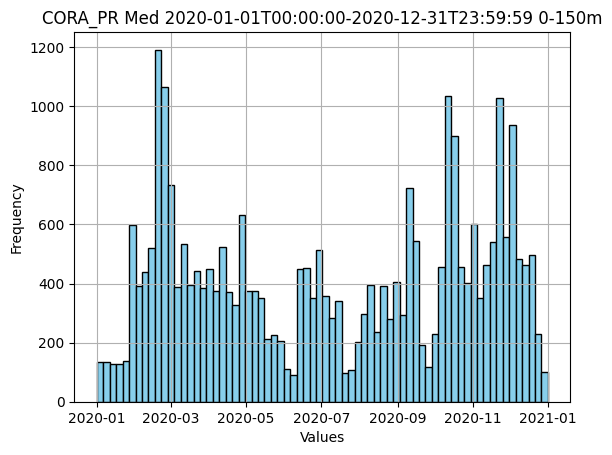

In [ ]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

par = "TIME"
data=df['TIME']
m=min(data)
M=max(data)
print(m,M)
data=df['TIME'].unique()
plt.hist(data, bins=70, color='skyblue', edgecolor='black')
#plt.ylim((0,310))
#plt.xlim(mm,MM)
plt.grid()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f"{BDI} {regionname} {mindate}-{maxdate} {mindepth}-{maxdepth}m")
plt.show()

#### Plotting of results

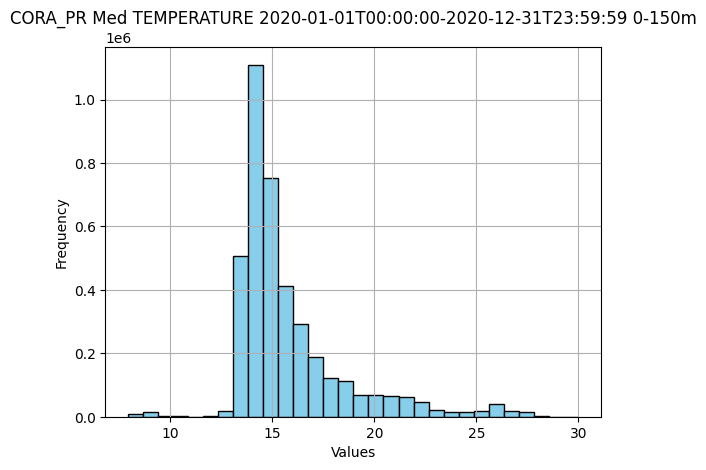

7.931000232696533 30.020000457763672


In [35]:
parameter = "TEMPERATURE"
tdata=df[parameter]
plt.hist(tdata, bins=30, color='skyblue', edgecolor='black')
plt.grid()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")
plt.show()
print(min(tdata),max(tdata))

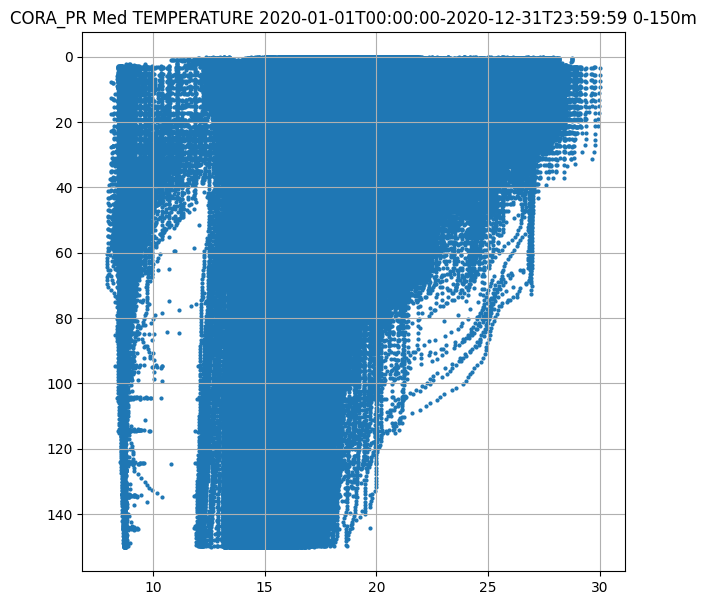

In [36]:
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df, x=parameter, y='DEPTH', s=4)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")
plt.show()

In [37]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="jet", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label=parameter)
cbar.set_label(f"{parameter} [C]")

plt.title(f"{regionname} {BDI} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")

plt.show()

NameError: name 'ccrs' is not defined

<Figure size 1500x1000 with 0 Axes>

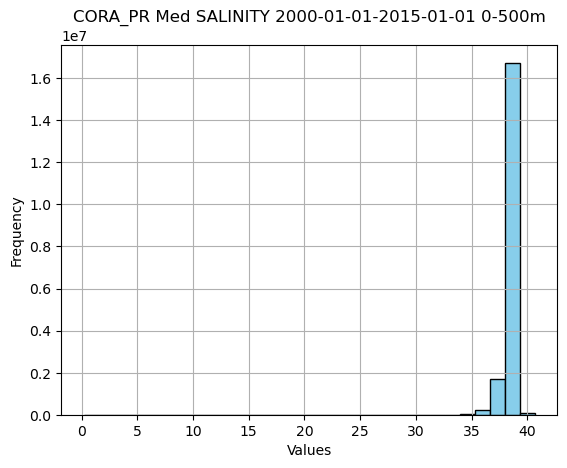

0.3790000081062317 30.68199920654297


In [ ]:
parameter = "SALINITY"
sdata=df[parameter]
plt.hist(sdata, bins=30, color='skyblue', edgecolor='black')
#plt.xlim((9,13))
plt.grid()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")
plt.show()
print(min(tdata),max(tdata))

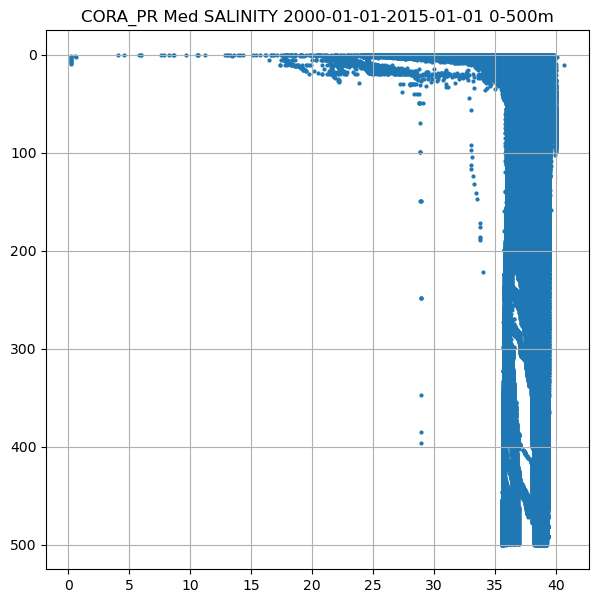

In [ ]:
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df,x=parameter, y='DEPTH', s=4)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")
plt.show()

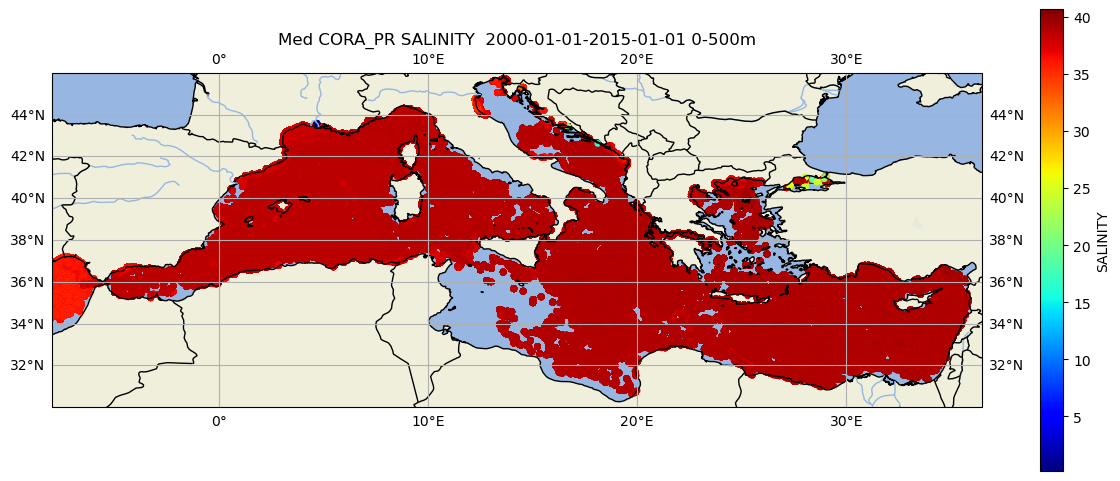

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="jet", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label=parameter)
cbar.set_label(f"{parameter}")

plt.title(f"{regionname} {BDI} {parameter}  {mindate}-{maxdate} {mindepth}-{maxdepth}m")

plt.show()